In [1]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
base_dir = '/content/drive/My Drive/deeplearn/'
!ls "/content/drive/My Drive/deeplearn/"

test  train  validation


In [3]:
# Menentukan Direktori 
test_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [4]:
# Menentukan Direktori Isi Bahan
car_dir = os.path.join(test_dir, 'car/')
bike_dir = os.path.join(test_dir, 'bike/')

print('Jumlah data train tiap kelas')
print('Jumlah gambar mobil  :', len(os.listdir(car_dir)))
print('Jumlah gambar motor  :', len(os.listdir(bike_dir)))

Jumlah data train tiap kelas
Jumlah gambar mobil  : 57
Jumlah gambar motor  : 182


In [5]:
# Direktori Isi data training
car_train = os.path.join(train_dir, 'car/')
bike_train = os.path.join(train_dir, 'bike/')

# Direktori isi data validasi
car_validation = os.path.join(validation_dir, 'car/')
bike_validation = os.path.join(validation_dir, 'bike/')

In [6]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size : total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

# Jumlah pembagian data training dan testing
train_ratio = 0.9

### Pembagian Training dan Validation
# Training
source_00 = car_dir
train_00 = car_train
val_00 = car_validation
train_val_split(source_00, train_00, val_00, train_ratio)

# Validation
source_01 = bike_dir
train_01 = bike_train
val_01 = bike_validation
train_val_split(source_01, train_01, val_01, train_ratio)

In [7]:
print('Total Car Keseluruhan  :', len(os.listdir(car_dir)))
print('Total Car Train        :', len(os.listdir(car_dir)))
print('Total Car Validation   :', len(os.listdir(car_dir)))

Total Car Keseluruhan  : 57
Total Car Train        : 57
Total Car Validation   : 57


In [8]:
print('Total Bike Keseluruhan  :', len(os.listdir(bike_dir)))
print('Total Bike Train        :', len(os.listdir(bike_dir)))
print('Total BIke Validation   :', len(os.listdir(bike_dir)))

Total Bike Keseluruhan  : 182
Total Bike Train        : 182
Total BIke Validation   : 182


In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 15,
    class_mode = 'categorical'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 15,
    class_mode = 'categorical'
)


Found 239 images belonging to 2 classes.
Found 239 images belonging to 2 classes.


In [12]:
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallBack()

# MODEL CNN

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.3, seed = 112),
    tf.keras.layers.Dense(500, activation = 'relu'),
    tf.keras.layers.Dropout(0.5, seed = 112),
    tf.keras.layers.Dense(2, activation = 'sigmoid'),
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [15]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch = 6,
    epochs = 100,
    validation_data = val_generator,
    validation_steps = 1,
    verbose = 1, 
    callbacks = [callbacks]
)

Epoch 1/100
6/6 [==============================] - 7s 1s/step - loss: 0.3552 - accuracy: 0.8539 - val_loss: 0.2535 - val_accuracy: 0.9333
Epoch 2/100
6/6 [==============================] - 4s 700ms/step - loss: 0.3065 - accuracy: 0.8876 - val_loss: 0.2173 - val_accuracy: 0.9333
Epoch 3/100
6/6 [==============================] - 6s 1s/step - loss: 0.2922 - accuracy: 0.8889 - val_loss: 0.0793 - val_accuracy: 1.0000
Epoch 4/100
6/6 [==============================] - 5s 709ms/step - loss: 0.2586 - accuracy: 0.8444 - val_loss: 0.1750 - val_accuracy: 0.9333
Epoch 5/100
6/6 [==============================] - 5s 801ms/step - loss: 0.2447 - accuracy: 0.8989 - val_loss: 0.2805 - val_accuracy: 0.9333
Epoch 6/100
6/6 [==============================] - 7s 1s/step - loss: 0.3905 - accuracy: 0.8333 - val_loss: 0.3736 - val_accuracy: 0.8667
Epoch 7/100
6/6 [==============================] - 4s 750ms/step - loss: 0.3747 - accuracy: 0.8667 - val_loss: 0.2192 - val_accuracy: 0.8667
Epoch 8/100
6/6 [=====

# Tingkat Akurasi dan Loss Model

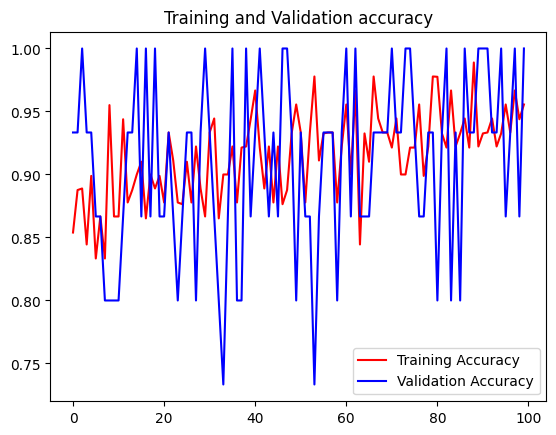

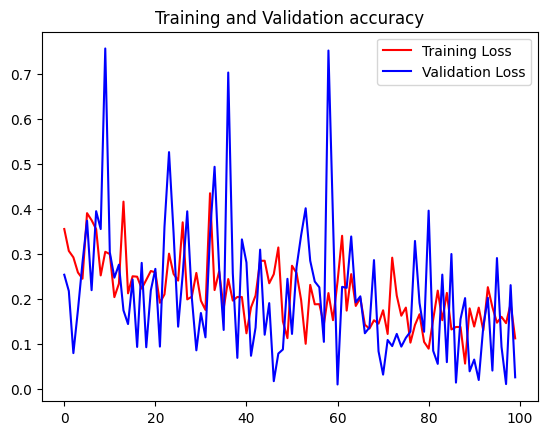

In [19]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()


# Mencoba Klasifikasi

Saving Bike (180).jpg to Bike (180).jpg
1/1 [==============================] - 0s 32ms/step
Bike (180).jpg
Gambar ini masuk dalam kelas bike


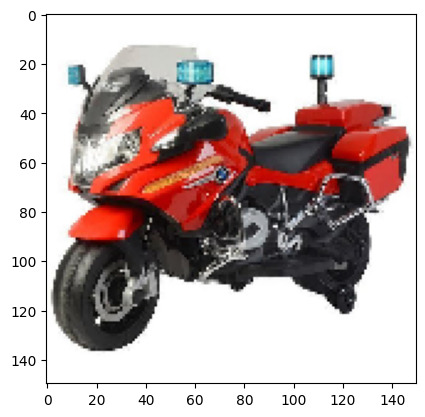

In [22]:
import numpy as np
import keras.utils as image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  # Prediksi Gambar
  path = fn
  img = image.load_img(path, target_size = (150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(train_dir)

  for j in range(42):
    if classes[0][j] == 1. :
      print('Gambar ini masuk dalam kelas', class_list[j-1])
      break